### Dataset Description
The dataset contains bird images, divided into train and test splits. The images are inside test_images and train_images folders.

The labels of the training images are inside train_images.csv file. In this file, the first column is image_path and the second one is the label (1 - 200). The test_images_samples.csv includes a row id with a dummy label. The final goal of the challenge is to change the label column to the predicted label.

The class_names.npy is a dictionary including the name of each label. Load the file using the following code: np.load("class_names.npy", allow_pickle=True).item()

The structure of the final submission should be exactly the same as the test_images_samples.csv! Otherwise, it will fail.

Files

- train_images - the training images
- test_images - the test images
- test_images_sample.csv - a sample submission file in the correct format
- test_images_path.csv - path to test file images
- train_images.csv - supplemental information about the data
- class_names.npy - this file includes the name of each label
- attributes.npy - this file includes the attributes which are extra information for each class.
- attributes.txt - this file includes the attribute names which are extra information for each class.

### Ideas and links: 

1. Train from scratch 
1. Use pretrained cnn (resnet18) and finetune <- not allowed>
1. Use pretrained and do feature extraction <- not allowed>

**complete tutorials**
- [Link](https://docs.pytorch.org/tutorials/beginner/transfer_learning_tutorial.html) to tutorial on pytorch
- [link](https://www.youtube.com/watch?v=t6oHGXt04ik) to tutorial on transfer learning with a resnet on youtube

**Creating a custom dataset**
- [link](https://docs.pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files) To pytorch tutorial of creating a custom dataset for your files


In [2]:
# Setup and imports
import numpy as np
import pandas as pd
import numpy as np
import os
from PIL import Image
import torch
import torchvision

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


**Exploring class features**

In [10]:
class_names = np.load("class_names.npy", allow_pickle=True).item()
print(F"First class: {class_names}") 
attributes = np.load("attributes.npy", allow_pickle=True)
print(F"Attributes shape: {attributes.shape}") 
print(attributes[199])

First class: {np.str_('001.Black_footed_Albatross'): 1, np.str_('002.Laysan_Albatross'): 2, np.str_('003.Sooty_Albatross'): 3, np.str_('004.Groove_billed_Ani'): 4, np.str_('005.Crested_Auklet'): 5, np.str_('006.Least_Auklet'): 6, np.str_('007.Parakeet_Auklet'): 7, np.str_('008.Rhinoceros_Auklet'): 8, np.str_('009.Brewer_Blackbird'): 9, np.str_('010.Red_winged_Blackbird'): 10, np.str_('011.Rusty_Blackbird'): 11, np.str_('012.Yellow_headed_Blackbird'): 12, np.str_('013.Bobolink'): 13, np.str_('014.Indigo_Bunting'): 14, np.str_('015.Lazuli_Bunting'): 15, np.str_('016.Painted_Bunting'): 16, np.str_('017.Cardinal'): 17, np.str_('018.Spotted_Catbird'): 18, np.str_('019.Gray_Catbird'): 19, np.str_('020.Yellow_breasted_Chat'): 20, np.str_('021.Eastern_Towhee'): 21, np.str_('022.Chuck_will_Widow'): 22, np.str_('023.Brandt_Cormorant'): 23, np.str_('024.Red_faced_Cormorant'): 24, np.str_('025.Pelagic_Cormorant'): 25, np.str_('026.Bronzed_Cowbird'): 26, np.str_('027.Shiny_Cowbird'): 27, np.str_('0

### Setting up dataset and dataloaders
creating train and validation set (80:20)

In [3]:
from torchvision.io import read_image
from torchvision import transforms
from torch.utils.data import DataLoader, random_split

torch.manual_seed(42)

class BirdDataset():
    def __init__(self, annotations_file, img_dir, img_col_index=0, label_col_index=1, transform=None, target_transform=None):
        """
        image_col_index: troubleshooting different csv formats( 0 for train , 1 for test)
        label_col_index: (1 for train, 2 for test)
        """

        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.img_col_index = img_col_index     
        self.label_col_index = label_col_index 
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        raw_val = self.img_labels.iloc[idx, self.img_col_index]
        
        
        filename = str(raw_val)
        filename = os.path.basename(filename)  
        img_path = os.path.join(self.img_dir, filename)
        image = read_image(img_path)
        
        #had greyscale images, force to three channels
        if image.shape[0] == 1:
            image = image.repeat(3, 1, 1)

            
    
        label = self.img_labels.iloc[idx, self.label_col_index] 
        # map 1–200  0–199 for CrossEntropyLoss
        label = int(label) - 1

    
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
            
        return image, label

train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

valtest_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [4]:
from torch.utils.data import Subset

train_data = BirdDataset(
    annotations_file='train_images.csv',
    img_dir='train_images/train_images',
    transform=train_transform, #augment
    img_col_index=0,
    label_col_index=1
)

val_data = BirdDataset(
    annotations_file='train_images.csv',
    img_dir='train_images/train_images',
    transform=valtest_transform, #No augmentation
    img_col_index=0,
    label_col_index=1
)

#split indices
dataset_size = len(train_data)
indices = list(range(dataset_size))
split = int(np.floor(0.2 * dataset_size))


np.random.seed(42)
np.random.shuffle(indices) 

train_indices, val_indices = indices[split:], indices[:split]

train_set = Subset(train_data, train_indices)
val_set = Subset(val_data, val_indices)

#Setting up Dataloaders
train_loader = DataLoader(train_set, batch_size = 32, shuffle = True )
val_loader = DataLoader(val_set, batch_size = 32, shuffle = False)

images, labels = next(iter(train_loader))
print(f"Batch size: {images.shape}")


Batch size: torch.Size([32, 3, 224, 224])


**Setting up test set**

In [5]:
test_dataset = BirdDataset(
    annotations_file='test_images_path.csv', 
    img_dir='test_images/test_images',
    transform=valtest_transform,
    img_col_index=1,  
    label_col_index=2
)

test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = False)
print(f'length testset = {len(test_dataset)}')

test_images, _ = next(iter(test_loader))
print(f"Test batch shape: {test_images.shape}")

length testset = 4000
Test batch shape: torch.Size([32, 3, 224, 224])


**Load a batch with labels for a manual check**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Labels in batch: [127, 111, 120, 13, 121, 32, 16, 49, 62, 126, 65, 34, 15, 125, 106, 60, 49, 40, 45, 2, 12, 38, 15, 48, 70, 35, 152, 100, 97, 38, 44, 145]


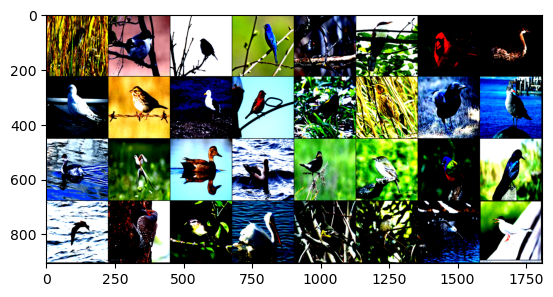

In [6]:
import matplotlib.pyplot as plt

def show_img(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

print("Labels in batch:", labels.tolist())
show_img(torchvision.utils.make_grid(images, nrow = 8))

### Convolutional Neural Network

In [12]:
import torch.nn as nn
import torch.nn.functional as F

class Net2(nn.Module):
    def __init__(self, num_classes): #With num_classes already define the last layers output
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,32, kernel_size= 3, padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(64,128, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.global_pool = nn.AdaptiveAvgPool2d((1,1))

        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512,1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024,num_classes)
        )

    def forward(self, x):
        x= self.layer1(x)
        x= self.layer2(x)
        x= self.layer3(x)
        x= self.layer4(x)
        x= self.layer5(x)

        x= self.global_pool(x)

        x = x.view(x.size(0), -1)

        x = self.fc(x)
        return x

In [15]:
import torch.optim as optim

num_classes = len(class_names)
model = Net2(num_classes).to(device)
print(model)
criterion = nn.CrossEntropyLoss(label_smoothing=.1)
optimizer = optim.Adam(model.parameters(), lr = 0.001, weight_decay=0.0001)
schedular = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', factor =0.1, patience=3)



Net2(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNo

In [16]:
n_epoch = 30
best_acc = 0.0

for epoch in range(n_epoch):
    #train
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)

    #val
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():           
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_acc = 100.0 * correct / total

    schedular.step(avg_val_loss)
    current_lr = optimizer.param_groups[0]['lr']

    print(
        f"Epoch {epoch+1}/{n_epoch}, "
        f"Train loss: {avg_train_loss:.3f}, "
        f"Val loss: {avg_val_loss:.3f}, "
        f"Val acc: {val_acc:.1f}%,"
        f"lr: {current_lr:.4f}"
    )
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")
        print(F"saved new best model with {val_acc:.2f} acc")
print(F"training_complete, best valacc: {best_acc:.2f}")


Epoch 1/30, Train loss: 5.279, Val loss: 5.216, Val acc: 0.6%,lr: 0.0010
saved new best model with 0.64 acc
Epoch 2/30, Train loss: 5.126, Val loss: 5.128, Val acc: 1.5%,lr: 0.0010
saved new best model with 1.53 acc
Epoch 3/30, Train loss: 5.048, Val loss: 5.100, Val acc: 1.9%,lr: 0.0010
saved new best model with 1.91 acc
Epoch 4/30, Train loss: 4.995, Val loss: 5.038, Val acc: 3.3%,lr: 0.0010
saved new best model with 3.31 acc
Epoch 5/30, Train loss: 4.953, Val loss: 5.029, Val acc: 2.9%,lr: 0.0010
Epoch 6/30, Train loss: 4.903, Val loss: 4.977, Val acc: 3.2%,lr: 0.0010
Epoch 7/30, Train loss: 4.892, Val loss: 4.965, Val acc: 3.8%,lr: 0.0010
saved new best model with 3.82 acc
Epoch 8/30, Train loss: 4.840, Val loss: 4.974, Val acc: 3.4%,lr: 0.0010
Epoch 9/30, Train loss: 4.829, Val loss: 4.981, Val acc: 3.1%,lr: 0.0010
Epoch 10/30, Train loss: 4.787, Val loss: 4.906, Val acc: 3.6%,lr: 0.0010
Epoch 11/30, Train loss: 4.767, Val loss: 4.954, Val acc: 2.7%,lr: 0.0010
Epoch 12/30, Train l

In [18]:
model.load_state_dict(torch.load('best_model.pth'))
model.to(device)
model.eval()

Net2(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNo

In [19]:
all_predictions = []

with torch.no_grad(): # Don't calculate gradients
    for images, _ in test_loader: 
        images = images.to(device)
        
        # Forward pass
        outputs = model(images)
        
        # Get the class with the highest probability
        _, predicted = torch.max(outputs.data, 1)
        
        all_predictions.extend(predicted.cpu().numpy())

submission = pd.read_csv('test_images_sample.csv')

# is length correct
if len(submission) != len(all_predictions):
    print(f"Sample has {len(submission)} rows but predicted {len(all_predictions)}")

# Add 1 because subtracted 1 in the Dataset class
submission['label'] = [p + 1 for p in all_predictions]

submission.to_csv('submission.csv', index=False)
print("submission.csv saved")

submission.csv saved
